# EVALUATING DATA SCIENTIST JOB POSTINGS

PROCESS OF METHODS:

SCRAPING
- 1: Scrape jobs from Indeed.com.
- 2: Scrape job descriptions from root job post.
- 3: Scrape employer salary data from Payscale.com.

FILTERING
- 4: Filter down to job posts that have "Data Scientist" in the title.
- 5: Get keywords from these "Data Scientist" job posts by using TFIDF vectorizer.
- 6: Using the TFIDF scores as weights, analyze ALL job posts.
- 7: Use the TFIDF scores for each job post to filter to the most "Data Sciencey" jobs.
- 8: Use the TFIDF score for each keyword in job titles as well.

WEIGHTING
- 9: Extract salary data from job post text for all "Data Sciencey" jobs.
- 10: For each company, calculate the percentage increase from the median salary to the "Data Science" salary.
- TEST: Calculate the percentage increase for keywords in the job titles. (Like Chief, Senior, etc.)

ESTIMATING
- 11: For job posts without salary data, use the Data Science salary weight to estimate a salary for each job post relative to the company.

MODELING
- 12: Run all of the features through a Random Forest model to find what most influences a job being above or below the median salary.
- 13: Run all of the features through a Logistic Regression model. Compare coefficients to feature importance from Random Forest and also adjust the threshold to minimize False Positives.

VISUALIZATIONS
- Several visuals to demonstrate what was done.

In [653]:
from bs4 import BeautifulSoup
from time import sleep
import random
import requests
import urllib
from readability.readability import Document
from html_table_parser import parser_functions as parse
import re

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--incognito")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn import svm, linear_model
from sklearn.grid_search import GridSearchCV

# SCRAPING

### 1: Scrape jobs from Indeed.com

Below is the indeed scraper that was run to get a dataframe that has title, company name, referral link, salary range/description, and the location of the job posts.

```python
#Dataframe we will store the collected data.
indeed_jobs = pd.DataFrame(columns=["title","company","url", "srange", "location"])
#Locations we're going to search through.
locations = ['Washington, DC', 'Herndon, VA','Atlanta, GA', 'New York, NY']
#Function to run for the search.
for i in locations:    
    #open Chrome
    driver = webdriver.Chrome(chrome_options=chrome_options)
    #navigate to indeed.com
    driver.get("https://www.indeed.com/")
    # find the search position
    elem = driver.find_element_by_name("q")
    # type in data scientist
    elem.send_keys("Data Scientist")
    # find the location position
    elem_loc = driver.find_element_by_name("l")
    # clear autofilled data
    elem_loc.clear()
    # type in the next location in my list.
    elem_loc.send_keys(i)
    # click search
    elem.send_keys(Keys.RETURN)
    #close the popup that appears.
    #driver.find_element_by_xpath(".//div[@id='prime-popover-x']/button").click()
    #Filter the search results to only have full-time jobs.
    driver.find_element_by_link_text('Full-time').click()
    #The number of jobs returned from the search. Divide by 10 to get how many times you should click the next button.
    end = int(BeautifulSoup(driver.page_source).find('div', {'id':'searchCount'}).text.partition('of ')[-1].replace(',',''))/12     
    #Indeed only lets you view the first 1,000 jobs of each search. If more than 1,000 jobs are returned we'll
    #adjust the end number to move on after its viewed all that it is allowed.
    if end > 100:
        end = 100
    #Function to return the elements of the search.
    for i in xrange(1,end):
        soup = BeautifulSoup(driver.page_source,'html.parser', from_encoding="utf-8")
        try:
            driver.find_element_by_link_text('No, thanks').click()
        except:
            for entry in soup.find_all('div', {'class':'  row  result'}):
                title = entry.find('a').text.encode('utf-8')
                company = entry.find('span', {'itemprop':'name'}).text.encode('utf-8')
                location = entry.find('span', {'itemprop':'jobLocation'}).text.encode('utf-8')
                srange = []
                try:
                    salary = entry.find('td', {'class':'snip'}).text.encode('utf-8')
                    srange.append(salary)
                except:
                    srange.append(np.nan)
                #description = entry.find('span', {'itemprop':'description'}).text
                url = "http://indeed.com" + entry.find('a').get('href')
                indeed_jobs.loc[len(indeed_jobs)]=[title, company, url, srange, location]
        sleep(float(round(random.uniform(1.5, 5.9),1))) #sleep before next step.
        driver.find_element_by_link_text('Next »').click() #click the next button for search results.
        print indeed_jobs.shape
    #close the driver.
    driver.close()

#Remove any duplicated rows.
print "Shape before duplicates removed =", indeed_jobs.shape
indeed_jobs = indeed_jobs.drop_duplicates(['url'])
print "Shape after duplicates removed =",indeed_jobs.shape

#backup the scraped jobs to csv.
indeed_jobs.to_csv('data/FULL_TIME_INDEED_SCRAPED_DATA_RAW.csv')
```

### 2: Scrape job descriptions from root job post.

In [654]:
#Bring in the scraped csv from the above scraper.
scraper1_data = pd.read_csv('data/FULL_TIME_INDEED_SCRAPED_DATA_RAW.csv')
scraper2 = pd.DataFrame(scraper1_data)
scraper2.drop(['Unnamed: 0'], axis=1, inplace=True)
print scraper2.shape
scraper2.head(2)

(2132, 5)


,title,company,url,srange,location
0,Forensic Scientist (Crime Scene),\n Dept of Forensic Sciences,http://indeed.com/rc/clk?jk=70192ba18fa061a8&f...,"['\n$61,491 - $79,275 a year\n\n\nAnd knowledg...","Washington, DC"
1,Data Scientist,\n Excella Consulting,http://indeed.com/rc/clk?jk=42cb30526e07b4ec&f...,['\n\n\nUsing machine learning and data mining...,"Washington, DC 20006 (Foggy Bottom area)"


Below is the scraper that we used to get the job descriptions and resolve any encoding/formatting errors that arose from those descriptions.
```python
#A function we will use later to strip out the html tags.
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)
#empty list to hold the job descriptions.
desc = []
for i in scraper2['url']:
    try:
        html = urllib.urlopen(i).read()
        readable = Document(html).summary()
        desc.append(str(readable))
    except:
        desc.append(np.nan)
    print len(desc)
    #sleep(float(round(random.uniform(2.5, 5.2),1))) #sleep before next step.
#set scraped list to a column in our dataframe.
scraper2['desc'] = desc
#unicode decoding attempt.
desc_unicode = []
for i in scraper2['desc']:
    try:
        text = i.encode('utf-8', 'replace')
        desc_unicode.append(text)
    except:
        desc_unicode.append(np.nan)
scraper2['desc'] = desc_unicode
print scraper2['desc'].isnull().sum()
#format all the column values to strings.
scraper2['desc'] = [str(job) for job in scraper2['desc']]
#strip out the html tags.
scraper2['desc'] = [striphtml(job) for job in scraper2['desc']]
#remove the formatting annotations.
scraper2['desc'] = [i.translate(None, '\t\n') for i in scraper2['desc']]
scraper2['company'] = [co.translate(None, '\t\n') for co in scraper2['company']]
#remove any this formatting errors that doesn't seem to go away.
scraper2['desc'] = [x.replace('&#13;', ' ') for x in scraper2['desc']]
#check again for duplicates.
print "Shape before duplicates removed =", scraper2.shape
scraper2 = scraper2.drop_duplicates(['url'])
print "Shape after duplicates removed =",scraper2.shape
#backup the scraped job descriptions to csv.
scraper2.to_csv('data/SCRAPED_JOB_DESCRIPTION_DATA_RAW.csv')
```

### 3: Scrape salary and benefits data for employer from Payscale.com

In [655]:
#Bring in the scraped csv from the above scraper.
scraper2_data = pd.read_csv('data/SCRAPED_JOB_DESCRIPTION_DATA_RAW.csv')
indeed = pd.DataFrame(scraper2_data)
indeed.drop(['Unnamed: 0'], axis=1, inplace=True)
print indeed.shape
indeed.head(2)

(2132, 6)


,title,company,url,srange,location,desc
0,Forensic Scientist (Crime Scene),Dept of Forensic Sciences,http://indeed.com/rc/clk?jk=70192ba18fa061a8&f...,"['\n$61,491 - $79,275 a year\n\n\nAnd knowledg...","Washington, DC",Forensic Scientist (Crime Scene)CS-401-11Caree...
1,Data Scientist,Excella Consulting,http://indeed.com/rc/clk?jk=42cb30526e07b4ec&f...,['\n\n\nUsing machine learning and data mining...,"Washington, DC 20006 (Foggy Bottom area)",Please Enable Cookies to ContinuePlease enabl...


In [656]:
df_company = indeed.groupby('company').count()
df_company = df_company.reset_index()
print 'Number of companies =', len(df_company['company'])
df_company.head()

Number of companies = 946


,company,title,url,srange,location,desc
0,1010data,2,2,2,2,2
1,2U,2,2,2,2,2
2,3M,1,1,1,1,1
3,ADP,21,21,21,21,21
4,AECOM,1,1,1,1,0


Below is the code that was used to scrape company salary data from payscale.com.

```python
#Empty dataframe to hold our results.
ds_salary = pd.DataFrame()
for i in df_company['company']:
    try:
        #open Chrome
        driver = webdriver.Chrome(chrome_options=chrome_options)
        #navigate to payscale.com
        driver.get("http://www.payscale.com/research/US/Country=United_States/Salary")
        #find the dropdown nav
        driver.find_element_by_xpath(".//a[@id='rcSearchDropDownBtn']").click()
        #find the employer option in the dropdown
        driver.find_element_by_xpath(".//li[@title='Employers']").click()
        #find the search bar
        elem = driver.find_element_by_name('str')
        #pass in the company name from the indeed post.
        elem.send_keys(i)
        #wait two seconds.
        sleep(3.0)
        #click on the first result from the suggested search options.
        driver.find_element_by_xpath(".//li[@class='ui-menu-item'][1]").click()
        #click on the years of experience tab on that companies page.
        driver.find_element_by_link_text('By Years Experience').click()
        #wait for the whole page to load.
        sleep(5.0)
        #soupify the page.
        soup = BeautifulSoup(driver.page_source,'html.parser', from_encoding="utf-8")
        #find the first table with the salaries by years of experience.
        table = soup.find_all('table', {'class':'tlf f11 w600'})[0]
        #parse the table into a dataframe.
        twodim_table = parse.make2d(table)
        df_scrape_test = pd.DataFrame(twodim_table)
        #drop the top and bottom rows in the dataframe to remove the header and footer from the html page.
        df_scrape_test.drop(0, axis=0, inplace=True)
        df_scrape_test = df_scrape_test[:-1]
        #remove the number of salaries data from the first column.
        df_scrape_test[0] = df_scrape_test[0].apply(lambda x: x.split('year')[0])
        #return only the first two columns of the dataframe.
        df_scrape_test.set_index(0, inplace=True)
        df_scrape_test = df_scrape_test.rename_axis(None)
        df_scrape_test.drop([2,3,4,5], axis=1, inplace=True)
        df_scrape_test = df_scrape_test.transpose()
        #Add in the company name so that you can compare against the data from Indeed.
        df_scrape_test['salary_company_source'] = soup.find('h1').text
        ds_salary = ds_salary.append(df_scrape_test)
    except:
        s2 = pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan], index=['1-4 ', '5-9 ', '10-19 ', '20 ', 'Less than 1 '])
        ds_salary = ds_salary.append(s2, ignore_index=True)
    driver.close()
    print "scraped %d out of %d" % (len(ds_salary), len(df_company['company']))
#since you're running this while you go to bed. Export it as a csv to check in the morning.
ds_salary.to_csv('data/PAYSCALE_SCRAPED_COMPANY_SALARY_DATA_RAW.csv')
```

Below is the code that was used to scrape company benefits data.
```python
ds_benefits = pd.DataFrame()
for i in df_company['company']:
    try:
        #open Chrome
        driver = webdriver.Chrome(chrome_options=chrome_options)
        #navigate to payscale.com
        driver.get("http://www.payscale.com/research/US/Country=United_States/Salary")
        #find the dropdown nav
        driver.find_element_by_xpath(".//a[@id='rcSearchDropDownBtn']").click()
        #find the employer option in the dropdown
        driver.find_element_by_xpath(".//li[@title='Employers']").click()
        #find the search bar
        elem = driver.find_element_by_name('str')
        #pass in the company name from the indeed post.
        elem.send_keys(i)
        #wait two seconds.
        sleep(3.0)
        #click on the first result from the suggested search options.
        driver.find_element_by_xpath(".//li[@class='ui-menu-item'][1]").click()
        #soupify the page.
        soup = BeautifulSoup(driver.page_source,'html.parser', from_encoding="utf-8")
        #find the first table with the salaries by years of experience.
        table = soup.find_all('table', {'class':'table table-condensed no-margin'})[0]
        #parse the table into a dataframe.
        twodim_table = parse.make2d(table)
        df_scrape_test = pd.DataFrame(twodim_table)
        #drop the rows and columns we don't need
        df_scrape_test = df_scrape_test[[0,1]]
        df_scrape_test.drop([0,2,3,4,7,9,10,11,12,13,14,15,16,17], inplace=True)
        df_scrape_test = df_scrape_test.transpose()
        df_scrape_test.columns = df_scrape_test.loc[0]
        df_scrape_test.drop(0, inplace=True)
        df_scrape_test['benefits_company_source'] = soup.find('h1').text
        ds_benefits = ds_benefits.append(df_scrape_test)
    except:
        s2 = pd.Series([np.nan, np.nan, np.nan, np.nan], index=['Job Satisfaction', 'Work Stress', 'Job Flexibility', 'Vacation Weeks'])
        ds_benefits = ds_benefits.append(s2, ignore_index=True)
    driver.close()
    print "scraped %d out of %d" % (len(ds_benefits), len(df_company['company']))
#since you're running this while you go to bed. Export it as a csv to check in the morning.
ds_benefits.to_csv('data/PAYSCALE_SCRAPED_BENEFITS_DATA_RAW.csv')
```

Run the scraper tonight.

```python
median_salary = []
for i in df_company['company']:
    try:        
        #open Chrome
        driver = webdriver.Chrome(chrome_options=chrome_options)
        #navigate to payscale.com
        driver.get("http://www.payscale.com/research/US/Country=United_States/Salary")
        #find the dropdown nav
        driver.find_element_by_xpath(".//a[@id='rcSearchDropDownBtn']").click()
        #find the employer option in the dropdown
        driver.find_element_by_xpath(".//li[@title='Employers']").click()
        #find the search bar
        elem = driver.find_element_by_name('str')
        #pass in the company name from the indeed post.
        elem.send_keys(i)
        #wait two seconds.
        sleep(3.0)
        #click on the first result from the suggested search options.
        driver.find_element_by_xpath(".//li[@class='ui-menu-item'][1]").click()
        #click on the by job tab on that companies page.
        driver.find_element_by_link_text('By Job').click()
        #get the url for the jobs page.
        url_source = driver.current_url
        #adjust it to have the data_scientist job.
        url = url_source[:-6] + 'Job/Data-Scientist'
        #Go to that url you just retrieved.
        driver.get(url)
        #wait for the whole page to load.
        sleep(5.0)
        #soupify the page.
        soup = BeautifulSoup(driver.page_source,'html.parser', from_encoding="utf-8")
        #empty list to hold median salary so we can clean up the data.
        med_salary = []
        #get the median salary from the chart.
        med_salary.append(soup.find('div', {'class':'you_label'}).text)
        #encode it properly
        #med_salary = [job.encode('ascii','ignore') for job in med_salary]
        #clean/format the returned text.
        for i in med_salary:    
            head, sep, tail = i.partition('MEDIAN:')
            tail = tail.translate(None, '\n')
            tail = tail.translate(None, ' ')
            #append it to the running list.
            median_salary.append(tail)
    except:
        median_salary.append(np.nan)
    print median_salary[-1]
    driver.close()
#Backup the scraper data to a csv.
ds_salary.to_csv('data/PAYSCALE_SCRAPED_DATASCIENCE_COMPANY_SALARY_DATA_RAW.csv')
```

In [657]:
#Bring in the scraped csv from the above scraper.
scraper3_data = pd.read_csv('data/PAYSCALE_SCRAPED_COMPANY_SALARY_DATA_RAW.csv')
payscale_scraped_a = pd.DataFrame(scraper3_data)
payscale_scraped_a.drop(['Unnamed: 0'], axis=1, inplace=True)
print payscale_scraped_a.shape
payscale_scraped_a.head(2)

(946, 6)


,1-4,10-19,20,5-9,Less than 1,salary_company_source
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN


In [658]:
#Bring in the scraped csv from the above scraper.
scraper4_data = pd.read_csv('data/PAYSCALE_SCRAPED_BENEFITS_DATA_RAW.csv')
payscale_scraped_b = pd.DataFrame(scraper4_data)
payscale_scraped_b.drop(['Unnamed: 0'], axis=1, inplace=True)
print payscale_scraped_b.shape
payscale_scraped_b.head(2)

(946, 5)


,Job Flexibility,Job Satisfaction,Vacation Weeks,Work Stress,benefits_company_source
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN


In [659]:
#Concat the two scraped dataframes from Payscale.com
df_payscale_scraped = pd.concat([payscale_scraped_a, payscale_scraped_b], axis=1)
print df_payscale_scraped.shape
df_payscale_scraped.head(2)

(946, 11)


,1-4,10-19,20,5-9,Less than 1,salary_company_source,Job Flexibility,Job Satisfaction,Vacation Weeks,Work Stress,benefits_company_source
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [660]:
#Add in the two csv's we scraped above to the company dataframe for us to check and make sure we scraped
#the right companies when we did the search.
#First cleaning up the company source columns so we can better evaluate the search results.
df_company_scraped = pd.concat([df_payscale_scraped, df_company], axis=1)
df_company_scraped['salary_company_source'] = df_company_scraped['salary_company_source'].str.replace('Average Salary for ', '')
df_company_scraped['salary_company_source'] = df_company_scraped['salary_company_source'].str.replace(' Employees', '')
df_company_scraped['benefits_company_source'] = df_company_scraped['benefits_company_source'].str.replace('Average Salary for ', '')
df_company_scraped['benefits_company_source'] = df_company_scraped['benefits_company_source'].str.replace(' Employees', '')
df_company_scraped.head()

,1-4,10-19,20,5-9,Less than 1,salary_company_source,Job Flexibility,Job Satisfaction,Vacation Weeks,Work Stress,benefits_company_source,company,title,url,srange,location,desc
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1010data,2,2,2,2,2
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2U,2,2,2,2,2
2,"$66,892","$95,353","$108,094","$81,724","$58,687",3M Company,Data Not Available,Extremely satisfied,2.7 Weeks,Stressful,3M Company,3M,1,1,1,1,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADP,21,21,21,21,21
4,"$59,207","$89,051","$112,775","$70,423","$53,903",Aecom Corporation,NaN,NaN,NaN,NaN,NaN,AECOM,1,1,1,1,0


In [661]:
#Export it as a csv to check we got the right companies.
df_company_scraped.to_csv('data/PAYSCALE_SCRAPED_DATA_ALL_RAW.csv')

In [662]:
#Bring in the cleaned CSV for companies scraped to join to our original dataframe.
payscale_clean = pd.read_csv('data/PAYSCALE_SCRAPED_DATA_ALL_CLEAN.csv')
payscale = pd.DataFrame(payscale_clean)
payscale.drop(['Unnamed: 0'], axis=1, inplace=True)
#Rename the column headers since excel screws them up.
payscale.rename(columns={'4-Jan':'1-4', '19-Oct':'10-19', '9-May':'5-9'}, inplace=True)
print payscale.shape
payscale.head(2)

(946, 10)


,company,1-4,10-19,20,5-9,Less than 1,Job Flexibility,Job Satisfaction,Vacation Weeks,Work Stress
0,1010data,NaN,NaN,NaN,"$91,233",NaN,NaN,NaN,NaN,NaN
1,2U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [663]:
#Take the spaces at the begining of the company out so that you can have more accurate data.
#company_test['company'] = [i.strip() for i in company_test['company']]

In [664]:
#Merge the two dataframes joining on 'company'. I know from running this before that the pay bracket of 1-4 was
#the most accurate for building an estimator for a data_scientists salary so I am going to only import that
#column here.
df = pd.merge(indeed, payscale[['company', '1-4', 'Job Flexibility', 'Job Satisfaction', 'Vacation Weeks', 'Work Stress']], how='left', on='company', copy=False, sort=False)
print df.shape
df.head()

(2132, 11)


,title,company,url,srange,location,desc,1-4,Job Flexibility,Job Satisfaction,Vacation Weeks,Work Stress
0,Forensic Scientist (Crime Scene),Dept of Forensic Sciences,http://indeed.com/rc/clk?jk=70192ba18fa061a8&f...,"['\n$61,491 - $79,275 a year\n\n\nAnd knowledg...","Washington, DC",Forensic Scientist (Crime Scene)CS-401-11Caree...,NaN,NaN,NaN,NaN,NaN
1,Data Scientist,Excella Consulting,http://indeed.com/rc/clk?jk=42cb30526e07b4ec&f...,['\n\n\nUsing machine learning and data mining...,"Washington, DC 20006 (Foggy Bottom area)",Please Enable Cookies to ContinuePlease enabl...,NaN,NaN,NaN,NaN,NaN
2,Data Scientist,Booz Allen Hamilton,http://indeed.com/rc/clk?jk=33f586dafa3deb4c&f...,"['\n\n\nApply expertise in advanced analytics,...","Washington, DC",Booz Allen Hamilt...,"$64,587",Extremely flexible,Highly satisfied,2.8 Weeks,Stressful
3,Data Scientist,Vox Media,http://indeed.com/rc/clk?jk=0a9009fd2170cf66&f...,['\n\n\nData Scientists are responsible for de...,"Washington, DC",U.S. Equal Opportunity Employment Informatio...,NaN,NaN,NaN,NaN,NaN
4,Data Scientist/Engineer,ICF International,http://indeed.com/rc/clk?jk=d29754cbfaf00024&f...,"['\n\n\nSpecifically, it provides psychologica...","Silver Spring, MD","Copyright 1992-2016 ICF International, Inc. Al...","$55,720",NaN,NaN,NaN,NaN


# FILTERING

We know that the median data scientist job salary in Wasington DC is 95,000. However when we scrape all the data scientist jobs posted by Indeed.com we get a median of 75,000. You can interprete that as there are not high paying data scientist jobs available or there are jobs that are not TRULY data scientist jobs being returned by the search. The assumption I chose was the latter because following that route would result in the cleanest data set possible to make a prediction. So below we are going to build a filter to see how many Data Scientist jobs are ACTUALLY being returned by the indeed.com search.

### 5: Filter jobs to only ones that have "Data Scientist" in the title.

In [665]:
#Convert the title column to uppercase so we can search easily.
df['title'] = map(lambda x: x.upper(), df['title'])
#Convert all the data here to strings to resolve a float error.
df['desc'] = df['desc'].astype(str)
#Convert the job descriptions to all uppercase words so that we are comparing apples to apples.
df['desc'] = map(lambda x: x.upper(), df['desc'])
#create a desc length column that we will use later.
df['desc_len'] = [len(i) for i in df['desc']]

In [666]:
ds_in_title = []
#Find the job titles that match the parameters below and put the results into a new column.
for i in df['title']:
    x = 0
    if 'DATA SCIENTIST' in i:
        x = 1
    if x >= 1:
        ds_in_title.append(1)
    else:
        ds_in_title.append(np.nan)
#Make a column with a 1 if its a match to the above search.
df['ds_in_title'] = ds_in_title

In [667]:
#Now filter this dataframe by only jobs that have data scientist in the title.
df1 = df[df['ds_in_title'] >= 1.0]
#Filter out job descriptions that are below 800 characters so that we get the best data possible here.
df1 = df1[df1['desc_len'] >= 800]
df1.shape

(277, 13)

### 6: Get keywords from these posts by using TFIDF vectorizer.

In [668]:
#Declare the X target as the job descriptions for only jobs with Data Scientist in the title.
X = df1['desc']

In [669]:
#Get the most important keywords across jobs that have data scientist in the title. We'll use these keywords
#to find other data science jobs that might not have data scientist in the title.
tfidfv = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0, stop_words = 'english', max_features=5000)
vect_model = tfidfv.fit_transform(X)
dense = vect_model.todense()

In [670]:
#Below is the list of most important words and their tfidf scores for importance to all the jobs that had
#data scientist in the title. We'll use these keyword weights to then get a weighted score for whether or not
#a certain job description is likely to be a data scientist job or not.
dense_test = pd.DataFrame(dense, columns=[tfidfv.get_feature_names()])
dense_test = dense_test.transpose()
dense_test['mean_tfidf'] = dense_test.mean(axis=1)
dense_test = dense_test[['mean_tfidf']]
dense_test = dense_test.reset_index()
dense_test = dense_test.sort_values('mean_tfidf', ascending=False)
dense_test.head(20)

,index,mean_tfidf
1117,data,0.125944
1782,experience,0.055743
4921,work,0.031810
311,analytics,0.031547
273,analysis,0.031239
622,business,0.029713
3946,science,0.029436
4503,team,0.027925
2635,learning,0.027859
4144,skills,0.027441


### 7: Using the TFIDF scores as weights analyze ALL job descriptions.

In [671]:
#We have 5,000 words in the TFIDF dataframe which is WAY more than we need. So lets filter that to be fewer
#keywords so its easier to track.
ds_keywords = dense_test[dense_test['mean_tfidf'] > 0.018]
ds_keywords.shape

(38, 2)

In [672]:
#Now lets format this dataframe into something that we can use to search through all our job descriptions.
ds_key_test = ds_keywords.transpose()
ds_key_test.columns = ds_key_test.iloc[0]
ds_key_test = ds_key_test.reset_index()
ds_key_test.drop(0, inplace=True)
ds_key_test.drop('index', axis=1, inplace=True)
ds_key_test.columns.name = None
ds_key_test.columns = map(lambda x: x.upper(), ds_key_test.columns)
ds_key_test

,DATA,EXPERIENCE,WORK,ANALYTICS,ANALYSIS,BUSINESS,SCIENCE,TEAM,LEARNING,SKILLS,...,MODELS,INCLUDING,TECHNOLOGY,JOB,ALGORITHMS,PROBLEMS,STRONG,LARGE,KNOWLEDGE,METHODS
1,0.125944,0.0557435,0.0318102,0.0315467,0.0312387,0.0297132,0.0294358,0.0279249,0.0278588,0.0274412,...,0.0201235,0.0199092,0.0195241,0.0194687,0.01901,0.0188275,0.0187724,0.0187513,0.0182813,0.0181009


In [673]:
#Split up the strings of each job description so we can search through every word.
df['desc_test'] = df['desc'].str.split()

In [674]:
#All that work for this sweet little search engine filtering thingy.
df_test = pd.DataFrame(columns=ds_key_test.columns)
for x in df['desc_test']:
    tl = []
    try:
        for i in ds_key_test.columns:
            if i in x:
                tl.append(ds_key_test[i].loc[1])
            else:
                tl.append(np.nan)
    except:
        tl.append(np.nan)
    append_test = dict(zip(list(ds_key_test.columns), tl))
    df_test = df_test.append(append_test, ignore_index=True)

/Users/nathanhall/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


### 8: Sum the TFIDF scores for each post and filter to the most "Data Sciency" jobs.

In [675]:
#Take the above resulting dataframe and sum up each job descprtion "Data Sciency" score.
df_test['likelihood'] = df_test.sum(axis=1)
df_test.shape

(2132, 39)

In [676]:
#Repeat the keyword analysis on the resulting job titles.
#Declare the X target as the titles for the jobs that were returned from our data scientist filter.
X2 = df['title']

In [677]:
#Get the most important keywords for these titles. This will serve as a better measure of the titles
#than the VERY many types that are in that column already.
tfidfv2 = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0, stop_words = 'english', max_features=5000)
vect_model2 = tfidfv2.fit_transform(X2)
dense2 = vect_model2.todense()

In [678]:
#Below is the list of most important words and their tfidf scores for importance to all the jobs that had
#data scientist in the title. We'll use these keyword weights to then get a weighted score for whether or not
#a certain job description is likely to be a data scientist job or not.
dense_test2 = pd.DataFrame(dense2, columns=[tfidfv2.get_feature_names()])
dense_test2 = dense_test2.transpose()
dense_test2['mean_tfidf'] = dense_test2.mean(axis=1)
dense_test2 = dense_test2[['mean_tfidf']]
dense_test2 = dense_test2.reset_index()
dense_test2 = dense_test2.sort_values('mean_tfidf', ascending=False)
dense_test2.head(15)

,index,mean_tfidf
3343,scientist,0.082106
992,data,0.077585
1035,data scientist,0.069339
3119,research,0.049677
160,analyst,0.049665
3567,senior,0.034015
3122,research analyst,0.033665
1346,engineer,0.029786
2297,manager,0.017995
3171,research scientist,0.016047


In [679]:
#We have 5,000 words in the TFIDF dataframe which is WAY more than we need. So lets filter that to be fewer
#keywords so its easier to track. We should be pretty strict on this since there shouldn't be that much
#variation.
ds_keywords2 = dense_test2[dense_test2['mean_tfidf'] > 0.018]
ds_keywords2.shape

(8, 2)

In [680]:
#Now lets format this dataframe into something that we can use to search through all our job titles.
ds_key_test2 = ds_keywords2.transpose()
ds_key_test2.columns = ds_key_test2.iloc[0]
ds_key_test2 = ds_key_test2.reset_index()
ds_key_test2.drop(0, inplace=True)
ds_key_test2.drop('index', axis=1, inplace=True)
ds_key_test2.columns.name = None
ds_key_test2.columns = map(lambda x: x.upper(), ds_key_test2.columns)
ds_key_test2

,SCIENTIST,DATA,DATA SCIENTIST,RESEARCH,ANALYST,SENIOR,RESEARCH ANALYST,ENGINEER
1,0.0821064,0.0775845,0.0693389,0.049677,0.0496651,0.0340151,0.0336652,0.0297859


In [681]:
#Split up the strings of each job description so we can search through every word.
df['title_test'] = df['title'].str.split()

In [682]:
#All that work for this sweet little search engine filtering thingy.
df_test2 = pd.DataFrame(columns=ds_key_test2.columns)
for x in df['title_test']:
    t2 = []
    try:
        for i in ds_key_test2.columns:
            if i in x:
                t2.append(ds_key_test2[i].loc[1])
            else:
                t2.append(np.nan)
    except:
        t2.append(np.nan)
    append_test2 = dict(zip(list(ds_key_test2.columns), t2))
    df_test2 = df_test2.append(append_test2, ignore_index=True)

/Users/nathanhall/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [683]:
#Take the above resulting dataframe and sum up each job title "Data Sciency" score.
df_test2['likelihood'] = df_test2.sum(axis=1)

In [684]:
df_test2.columns = [str(col) + '_title' for col in df_test2.columns]

In [685]:
df_test.columns = [str(col) + '_keyword' for col in df_test.columns]

In [686]:
#Concapt the resulting dataframes together
df_keywords = pd.concat([df_test, df_test2], axis=1)
print df_keywords.shape

(2132, 48)


In [687]:
#Concat that score to the original dataframe.
df = pd.concat([df, df_keywords], axis=1)
#Create a new dataframe that now filters our results to the most "Data Sciency" jobs.
print "df Shape Before Filter =", df.shape
#This threshold should remain near the same to catch the most "data sciencey" jobs.
df = df[df['likelihood_keyword'] > 0.52]
print "df Shape After Filter =", df.shape
df.sort_values('likelihood_keyword', ascending=False, inplace=True)
df.head(5)

df Shape Before Filter = (2132, 63)
df Shape After Filter = (472, 63)


,title,company,url,srange,location,desc,1-4,Job Flexibility,Job Satisfaction,Vacation Weeks,...,likelihood_keyword,SCIENTIST_title,DATA_title,DATA SCIENTIST_title,RESEARCH_title,ANALYST_title,SENIOR_title,RESEARCH ANALYST_title,ENGINEER_title,likelihood_title
1172,STATISTICAL CONSULTANT,Equifax,http://indeed.com/rc/clk?jk=e3db711f65629c93&f...,"['\n\n\nManipulate large data sets, integrate ...","Alpharetta, GA",STATISTICAL CONSULTANT APPLY JOB ...,"$60,404",Data Not Available,Extremely satisfied,2.7 Weeks,...,0.904738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2016,BUSINESS ANALYTICS MANAGER,Medidata Solutions,http://indeed.com/rc/clk?jk=eb009ead7e4f2013&f...,['\n\n\nManage data science projects involving...,"New York, NY 10003 (Greenwich Village area)",OUR IN...,"$52,118",NaN,NaN,NaN,...,0.835336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
29,DATA SCIENTIST,Ukpeagvik Iñupiat Corporation/Bowhead Fami...,http://indeed.com/rc/clk?jk=65885ab70c3dbd8c&f...,"['\n\n\nCrashes, The selected candidate will w...","Washington, DC",TRACKING CODE DTNH22-16-1780-F JOB CODE...,NaN,NaN,NaN,NaN,...,0.835324,0.082106,0.077585,NaN,NaN,NaN,NaN,NaN,NaN,0.159691
927,DATA SCIENTIST ( MACHINE LEARNING),IHS Markit,http://indeed.com/rc/clk?jk=493df6b925152ae3&f...,"['\n\n\nMachine learning, data mining, quantit...","Washington, DC",ABOUT IHS MARKIT IHS MARKIT HARNESSES DEEP SO...,NaN,NaN,NaN,NaN,...,0.828642,0.082106,0.077585,NaN,NaN,NaN,NaN,NaN,NaN,0.159691
1072,DATA SCIENTIST,Cotiviti,http://indeed.com/rc/clk?jk=c95e60155151f4e2&f...,['\n\n\nThis is a pioneering data scientist wh...,"Atlanta, GA",REQUISITION NUMBER 16-0948 TITLE DATA S...,NaN,NaN,NaN,NaN,...,0.818920,0.082106,0.077585,NaN,NaN,NaN,NaN,NaN,NaN,0.159691


# WEIGHTING

### 9: Extract salary data from job post text for ALL "Data Sciency" jobs.

In [688]:
#format the srange column so you can extract the salary data.
df['srange'] = df['srange'].str.replace('[', '')
df['srange'] = df['srange'].str.replace(']', '')
df['srange'] = df['srange'].str.replace(r"\\n", ' ')

#exctract salary data that matches the following formats.
df['srange1'] = df['srange'].str.extract('(.\d\d,\d\d\d - .\d\d,\d\d\d)', expand=True)
df['srange2'] = df['srange'].str.extract('(.\d\d,\d\d\d - .\d\d\d,\d\d\d)', expand=True)

In [689]:
#partition the strings in srange1 and srange2
low_range1 = []
high_range1 = []
for i in df['srange1']:
    try:
        head1, sep1, tail1 = i.partition(' - ')
        low_range1.append(head1)
        high_range1.append(tail1)
    except:
        low_range1.append(np.nan)
        high_range1.append(np.nan)
#Append the data to the dataframe that was extracted from the srange1 column.
df['low_srange1'] = low_range1
df['high_srange1'] = high_range1
#drop the srange column.
df.drop('srange1', axis=1, inplace=True)

#repeat the above step for srange2
low_range2 = []
high_range2 = []
for i in df['srange2']:
    try:
        head2, sep2, tail2 = i.partition(' - ')
        low_range2.append(head2)
        high_range2.append(tail2)
    except:
        low_range2.append(np.nan)
        high_range2.append(np.nan)
#Append the data to the dataframe that was extracted from the srange1 column.
df['low_srange2'] = low_range2
df['high_srange2'] = high_range2
#drop the srange2 column.
df.drop('srange2', axis=1, inplace=True)

#drop the srange column since we now have the data we need from it.
df.drop('srange', axis=1, inplace=True)

In [690]:
#exctract salary data that matches the format for a 6 figure job from each job description.
df['extract_test_high'] = df['desc'].str.extract('(\d\d\d,\d\d\d\.\d\d)', expand=True)
#extract salary data that matches the format for a 5 figure job.
df['extract_test'] = df['desc'].str.extract('(\d\d,\d\d\d\.\d\d)', expand=True)
#for comparison... extract the salary data that does not have decimal places but is five figures.
df['extract_test1'] = df['desc'].str.extract('(\d\d,\d\d\d)', expand=True)

In [691]:
#To accomplish this we need to reformat some columns.
format_cols = ['low_srange1', '1-4', 'high_srange1', 'low_srange2', 'high_srange2', 'extract_test_high', 'extract_test', 'extract_test1']
#Format all dollar value rows so that they can be converted to floats.
for i in df[format_cols]:
    df[i] = df[i].astype(str)
    df[i] = df[i].str.replace(',', '')
    df[i] = df[i].str.replace('$', '')
    df[i] = df[i].astype(float)

In [692]:
#Account for error values that may have been extracted. All our salary estimates should be over the median starting
#salary of an employee AT LEAST!
df[df[format_cols] < 45000.0] = np.nan
df[df[format_cols] > 140000.0] = np.nan

### 10: Calculate the percentage increase over the median salary at each company.

In [693]:
#We will also take the high and low range salary estimate from the post and average it together so that we're
#working with only one number.
df['post_estimate'] = df[['low_srange1', 'high_srange1', 'low_srange2', 'high_srange2', 'extract_test_high', 'extract_test', 'extract_test1']].mean(axis=1)
#drop all those srange columns now.
df.drop(['low_srange1', 'high_srange1', 'low_srange2', 'high_srange2', 'extract_test_high', 'extract_test', 'extract_test1'], axis=1, inplace=True)

In [694]:
df['post_estimate'].value_counts()

50000.000000     8
74000.000000     4
75000.000000     3
90000.000000     3
112946.666667    2
100000.000000    2
45000.000000     1
80000.000000     1
96366.500000     1
62000.000000     1
125000.000000    1
94411.600000     1
140000.000000    1
58000.000000     1
76000.000000     1
93159.333333     1
67419.000000     1
62338.000000     1
100306.500000    1
Name: post_estimate, dtype: int64

In [695]:
#Now we'll take the post_estimate and known data science salaries at that company and create an initial estimate.
#df['initial_estimate'] = df[['post_estimate', 'data_scientist_salary']].mean(axis=1)
#Now we're going to make a dataframe of only the data we can make our first two estimates off of.
df2 = df[['post_estimate']].dropna(thresh=1)
df2 = df2.join(df, lsuffix='_left', rsuffix='_right')
df2.drop(['post_estimate_left'], axis=1, inplace=True)
#Filter the dataframe to only have values from the 1-4 column. This will return just the posts that have BOTH
#1-4 year company data and the job post specific salary data.
df2 = df2[df2['1-4'] > 0]
print df2.shape

(10, 63)


In [696]:
#Now we'll use these job postings to calculate a percentage increase over a standard job at each of these companies.
df2['weight'] = (df2['post_estimate_right']/df2['1-4'])

In [697]:
#Average percentage increase over just normal year data that a data scientist salary should be making.
ds_generic_weight = df2['weight'].mean()
ds_generic_weight

1.2451427181054453

In [698]:
#now the same thing but for each company.
df3 = df2.groupby('company').mean()
df3 = df3.reset_index()
df4 = df3[['company', 'weight']]
df4

,company,weight
0,BAE Systems,1.418797
1,Centers for Disease Control and Preven...,1.661176
2,Central Intelligence Agency,1.023344
3,FactSet Research Systems,0.741228
4,Mars,1.127447
5,Teva Pharmaceuticals,0.828382
6,U.S. Department of Labor,1.686012


In [699]:
#Make a dictionary mapping function for the above companies.
weight_dict = df4.set_index('company').to_dict()['weight']

# ESTIMATING

You'll notice that above if we only used jobs that had salaries we'd have 49 out of every 560. That is why I built a salary estimator. With the salary data that is available for these companies if I use a weighted measure to estimate the salary of a data scientist then I will be able to keep posts that either have a salary range posted, a median data scientist salary posted, OR a median salary for a 1-4 year employee posted.

### 11: For jobs without a salary in the post use the Data Science salary weight to estimate a salary for each company.

In [700]:
#Add a column of company weights we calclated earlier to the dataframe.
df['co_weight'] = df['company'].map(weight_dict)
#Fill all the unknown weights for companies with the average increase of 25%.
df['co_weight'] = df['co_weight'].fillna(ds_generic_weight)

In [701]:
#Now calculate a weighted salary estimate for each of the "Data Sciency" jobs we have in our dataframe.
df['weighted_estimate'] = df['co_weight']*df['1-4']

In [702]:
#Now for the FINAL estimate we will average together the data that we have available to us.
df['estimate'] = df[['post_estimate', 'weighted_estimate']].mean(axis=1)

In [703]:
#Before we move on to modeling though we need to drop the jobs in our dataframe that did not end up with an estimate.
print "df shape before estimate =", df.shape
df = df[df['estimate'] > 0]
print "df shape after estimate =", df.shape
df.head()

df shape before estimate = (472, 66)
df shape after estimate = (219, 66)


,title,company,url,location,desc,1-4,Job Flexibility,Job Satisfaction,Vacation Weeks,Work Stress,...,RESEARCH_title,ANALYST_title,SENIOR_title,RESEARCH ANALYST_title,ENGINEER_title,likelihood_title,post_estimate,co_weight,weighted_estimate,estimate
1172,STATISTICAL CONSULTANT,Equifax,http://indeed.com/rc/clk?jk=e3db711f65629c93&f...,"Alpharetta, GA",STATISTICAL CONSULTANT APPLY JOB ...,60404.0,Data Not Available,Extremely satisfied,2.7 Weeks,Stressful,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,1.245143,75211.600744,75211.600744
2016,BUSINESS ANALYTICS MANAGER,Medidata Solutions,http://indeed.com/rc/clk?jk=eb009ead7e4f2013&f...,"New York, NY 10003 (Greenwich Village area)",OUR IN...,52118.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,1.245143,64894.348182,64894.348182
927,DATA SCIENTIST ( MACHINE LEARNING),IHS Markit,http://indeed.com/rc/clk?jk=493df6b925152ae3&f...,"Washington, DC",ABOUT IHS MARKIT IHS MARKIT HARNESSES DEEP SO...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.159691,50000.0,1.245143,NaN,50000.000000
1496,CHIEF DATA SCIENTIST,S&P GLOBAL,http://indeed.com/rc/clk?jk=307ac18e77a35c8a&f...,"New York, NY 10002 (Lower East Side area)",POSITION DESCRIPTION ...,67348.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.159691,NaN,1.245143,83857.871779,83857.871779
1355,PRINCIPAL DATA SCIENTIST,Aetna,http://indeed.com/rc/clk?jk=6a7a681f17bfde42&f...,"New York, NY 10016 (Gramercy area)",POSITION SUMMARY THE PRINCIPAL SCIENTIST PROVI...,55214.0,Data Not Available,Extremely satisfied,3.0 Weeks,Highly stressful,...,NaN,NaN,NaN,NaN,NaN,0.159691,NaN,1.245143,68749.310037,68749.310037


In [704]:
#Predict against the estimate.

In [706]:
df_regressor = df

In [707]:
target2 = df_regressor['estimate']

In [708]:
df_regressor.columns

Index([u'title', u'company', u'url', u'location', u'desc', u'1-4',
       u'Job Flexibility', u'Job Satisfaction', u'Vacation Weeks',
       u'Work Stress', u'desc_len', u'ds_in_title', u'desc_test',
       u'title_test', u'DATA_keyword', u'EXPERIENCE_keyword', u'WORK_keyword',
       u'ANALYTICS_keyword', u'ANALYSIS_keyword', u'BUSINESS_keyword',
       u'SCIENCE_keyword', u'TEAM_keyword', u'LEARNING_keyword',
       u'SKILLS_keyword', u'NEW_keyword', u'STATISTICAL_keyword',
       u'MACHINE_keyword', u'SCIENTIST_keyword', u'ABILITY_keyword',
       u'MACHINE LEARNING_keyword', u'SOLUTIONS_keyword',
       u'DATA SCIENTIST_keyword', u'DATA SCIENCE_keyword', u'USING_keyword',
       u'RESEARCH_keyword', u'YEARS_keyword', u'TOOLS_keyword',
       u'INFORMATION_keyword', u'DEVELOPMENT_keyword', u'TECHNICAL_keyword',
       u'COMPANY_keyword', u'WORKING_keyword', u'MODELS_keyword',
       u'INCLUDING_keyword', u'TECHNOLOGY_keyword', u'JOB_keyword',
       u'ALGORITHMS_keyword', u'PROBLEMS

In [709]:
df_regressor.drop(['1-4', 'post_estimate','weighted_estimate', 'estimate'], axis=1, inplace=True )

In [710]:
## ALTERNATIVE ESTIMATING
le = LabelEncoder()
X2 = df_regressor.apply(LabelEncoder().fit_transform)
y2 = le.fit_transform(target2)

/Users/nathanhall/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [711]:
#Get a train and teset dataset for the above variables to put into random forest.
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=.33, random_state=99)

In [712]:
#Run Random Forest on the data.
rf2 = RandomForestRegressor()
rf2_model = rf2.fit(X2_train, y2_train)
y2_pred = rf2.predict(X2_test)

print "RandomForest Cross_Val Score:\t", cross_val_score(rf2, X2_train, y2_train, cv=5).mean()
print "Train/Test RandomForest Score:\t", rf2.score(X2_test, y2_test)

RandomForest Cross_Val Score:	0.179160728784
Train/Test RandomForest Score:	-0.205902706264


In [721]:
X2_test.shape

(73, 62)

In [720]:
len(y2_pred)

73

In [724]:
X2_test['estimate'] = y2_test
X2_test['predicted'] = y2_pred

/Users/nathanhall/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/nathanhall/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# MODELING

### 12a. Format dataframe features into dummy variables.

In [541]:
df_keywords.drop(['likelihood_keyword', 'likelihood_title'], axis=1, inplace=True)

In [542]:
#Get the keywords for each job post as a dummy variable.
for x in df_keywords.columns:
    i_list = []
    for i in df[x]:
        if i > 0:
            i_list.append(1)
        else:
            i_list.append(np.nan)
    df[x] = i_list

In [543]:
model_dummies = pd.get_dummies(df[['ds_in_title', 'Job Flexibility', 'Job Satisfaction', 'Work Stress']], drop_first=True)

In [544]:
#Lets make a dataframe with all the things we think might be interesting to pass into a random forest model.
df_model = pd.concat([df, model_dummies], axis=1)

In [545]:
#Label each job post as being above or below the median to create our target.
target = [1 if x else 0 for x in df_model['estimate'] >= 85000]
#Dropping estimate from the model since that would be giving too much information to the random forest model.
df_model.drop(['estimate', '1-4', 'post_estimate', 'co_weight', 'weighted_estimate', 'title', 'company', 'url', 'location', 'desc', 'desc_test','title_test', 'Job Flexibility', 'Job Satisfaction', 'ds_in_title', 'Work Stress', 'Vacation Weeks', 'COMPANY', 'WORK', 'NEW', 'SKILLS'], axis=1, inplace=True)
print "Shape of the model dataframe =",df_model.shape

Shape of the model dataframe = (219, 56)


In [546]:
#Make a dataset for logistic regression.
from sklearn.preprocessing import StandardScaler

In [547]:
log_model = df_model

In [548]:
log_model['target'] = target

In [549]:
log_model = log_model.fillna(0.0)
log_model.head()

,desc_len,DATA_keyword,EXPERIENCE_keyword,WORK_keyword,ANALYTICS_keyword,ANALYSIS_keyword,BUSINESS_keyword,SCIENCE_keyword,TEAM_keyword,LEARNING_keyword,...,ENGINEER_title,likelihood_title,Job Flexibility_Extremely flexible,Job Flexibility_Highly flexible,Job Satisfaction_Highly satisfied,Job Satisfaction_Satisfied,Work Stress_Highly stressful,Work Stress_Somewhat stressful,Work Stress_Stressful,target
1172,4637,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2016,6052,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
927,7079,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.159691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1496,6500,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.159691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1355,4835,1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.159691,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [550]:
scaler = StandardScaler()
log_model1 = scaler.fit_transform(log_model1)

In [551]:
log_model1 = log_model.drop(['target', 'desc_len'], axis=1)

In [552]:
X1 = log_model1
y1 = log_model['target']

In [553]:
#Get a train and teset dataset for the above variables to put into random forest.
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=.33, random_state=99)

### 12: Run all of our features through a Random Forest model to find what most influences a job being above or below the median salary.

In [554]:
df_model.drop('target', axis=1, inplace=True)

In [555]:
le = LabelEncoder()
X = df_model.apply(LabelEncoder().fit_transform)
y = le.fit_transform(target)

In [556]:
#Get a train and teset dataset for the above variables to put into random forest.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=99)

In [557]:
#Grid_search on the data above to find the best parameters to pass to Random Forest
rf_grid = RandomForestClassifier(random_state=99, n_jobs=50)

#Parameter dictionary of settings options for the model we're passing grid search.
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [None,2,5,8],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'class_weight' : ['balanced', None]
}

#Instantiate grid search.
grid = GridSearchCV(rf_grid, param_grid, cv=5, scoring='accuracy')

#Fit the grid search to X, and y.
grid.fit(X_train, y_train)

#Store the best parameters in a variable.
params = grid.best_params_
print "Best score =", grid.best_score_
print params

Best score = 0.684931506849
{'max_features': 'log2', 'criterion': 'entropy', 'max_depth': None, 'class_weight': 'balanced'}


In [558]:
#Run Random Forest on the data.
rf = RandomForestClassifier(**params)
rf_model = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print "RandomForest Cross_Val Score:\t", cross_val_score(rf, X_train, y_train, cv=5).mean()
print "Train/Test RandomForest Score:\t", rf.score(X_test, y_test)

RandomForest Cross_Val Score:	0.684827586207
Train/Test RandomForest Score:	0.58904109589


In [559]:
#CONFUSION MATRIX FOR LOGISTIC REGRESSION
confusion = np.array(confusion_matrix(y_test, y_pred))

# calculate true positives, the number of 1s correctly predicted to be 1
print "TP =", confusion[0,0]
# calculate false positives, the number of 0s incorrectly predicted to be 1
print "FP =", confusion[1,0]
# calculate true negatives, the number of 0s correctly predicted to be 0
print "TN =", confusion[1,1]
# calculate false negatives, the number of 1s incorrectly predicted to be 0
print "FN =", confusion[0,1]
# print out the classification report as well.
print classification_report(y_test, y_pred)

TP = 36
FP = 20
TN = 7
FN = 10
             precision    recall  f1-score   support

          0       0.64      0.78      0.71        46
          1       0.41      0.26      0.32        27

avg / total       0.56      0.59      0.56        73



In [560]:
df_features = pd.DataFrame(columns=['Features', 'Importance (Gini Index)'])
df_features['Features'] = df_model.columns
df_features['Importance (Gini Index)'] = rf.feature_importances_
df_features.sort_values('Importance (Gini Index)', ascending=False, inplace=True)

In [561]:
#Grid_search on the data above to find the best parameters to pass to Logistic Regression
log_grid = linear_model.LogisticRegressionCV(random_state=99, n_jobs=-1, solver='newton-cg', penalty='l2')

#Parameter dictionary of settings options for the model we're passing grid search.
param_grid1 = {
    'Cs': [1,2,5,7,9],
    'cv' : [2,5],
    'scoring' : ['accuracy', 'r2'],
    'multi_class' : ['ovr', 'multinomial']
}
#Scoring to try = roc_auc, f1, precision, and accuracy

#Instantiate grid search.
grid1 = GridSearchCV(log_grid, param_grid1, cv=3, scoring='accuracy')

#Fit the grid search to X, and y.
grid1.fit(X1_train, y1_train)

#Store the best parameters in a variable.
params1 = grid1.best_params_
print "Best score =", grid1.best_score_
print params1

Best score = 0.602739726027
{'Cs': 5, 'multi_class': 'ovr', 'cv': 5, 'scoring': 'accuracy'}


In [562]:
#def logistic_vs_svm(X_train, X_test, y_train, y_test):
# Looking at logistic regression compared to our target to see what a baseline accuracy would be.
logistic = linear_model.LogisticRegressionCV(**params1)
logistic.fit(X1_train, y1_train)
print "----------------"
print "LOGISTIC REGRESSION CV ACCURACY SCORE"
print cross_val_score(logistic, X1_train, y1_train, cv=5, scoring='accuracy').mean()
#Show the r2 score as well.
print "----------------"
print "LOGISTIC REGRESSION R2 SCORE"
print cross_val_score(logistic, X1_train, y1_train, cv=5, scoring='r2').mean()
#Logistic confusion matrix
y1_pred = logistic.predict(X1_test)
#CONFUSION MATRIX FOR LOGISTIC REGRESSION CV
confusion = np.array(confusion_matrix(y1_test, y1_pred))
# calculate true positives, the number of 1s correctly predicted to be 1
print "------------------"
print "LOGISTIC REGRESSION CONFUSION MATRIX"
print "TP =", confusion[0,0]
# calculate false positives, the number of 0s incorrectly predicted to be 1
print "FP =", confusion[1,0]
# calculate true negatives, the number of 0s correctly predicted to be 0
print "TN =", confusion[1,1]
# calculate false negatives, the number of 1s incorrectly predicted to be 0
print "FN =", confusion[0,1]

----------------
LOGISTIC REGRESSION CV ACCURACY SCORE
0.65724137931
----------------
LOGISTIC REGRESSION R2 SCORE
-0.41568627451
------------------
LOGISTIC REGRESSION CONFUSION MATRIX
TP = 34
FP = 17
TN = 10
FN = 12


In [563]:
df_model['target'] = target
df_model['target'].value_counts()

0    132
1     87
Name: target, dtype: int64

In [564]:
logistic_coef = []
for i in logistic.coef_.tolist():
    for j in i:
        logistic_coef.append(j)
print len(logistic_coef)

55


In [565]:
log_features = pd.DataFrame(columns=['Features', 'Importance (coef)'])
log_features['Features'] = X1_train.columns
log_features['Importance (coef)'] = logistic_coef
log_features.sort_values('Importance (coef)', ascending=False, inplace=True)

In [566]:
#log_features.drop('Importance (Gini Index)', axis=1, inplace=True)
#log_features.drop(0, inplace=True)
log_features.head()

,Features,Importance (coef)
53,Work Stress_Somewhat stressful,30.475260
0,DATA_keyword,26.847726
43,ANALYST_title,23.199324
33,PROBLEMS_keyword,21.660053
13,SCIENTIST_keyword,18.722064


###### Starting accuracy
169/(169+45) == 0.789

We have an increase in accuracy here of about 8%.

# VISUALIZATIONS

In [567]:
#Number of jobs we analyzed and got salary data for.
df = df[df['estimate'] > 0]
df.shape

(219, 66)

In [568]:
#Median salary of our data.
df.estimate.median()

76353.39661694401

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13ac7e710>]], dtype=object)

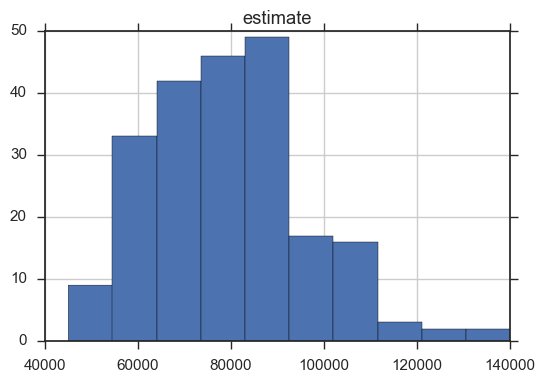

In [569]:
#Plot it on a histogram.
df.hist(column='estimate')

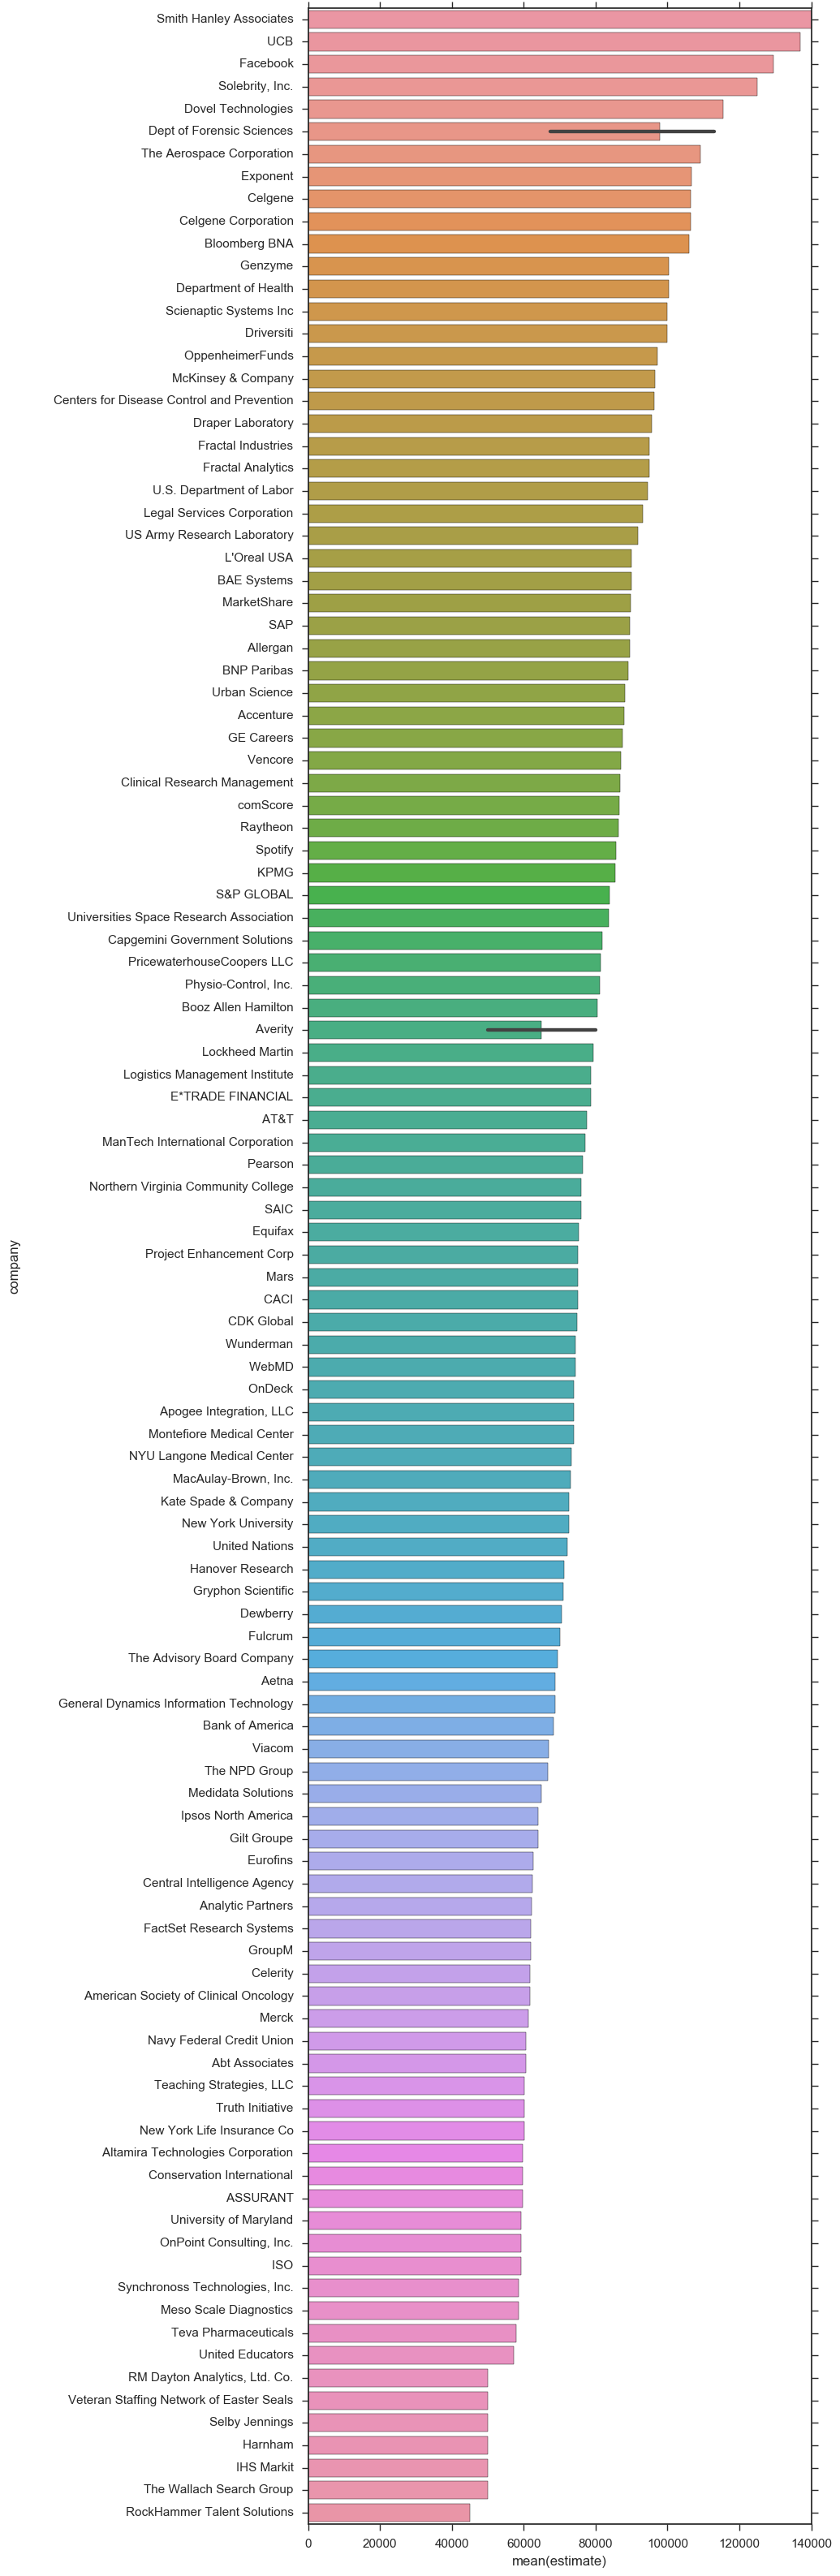

In [570]:
#Sort the dataframe so that we can have a better output
df.sort_values('estimate', ascending=False, inplace=True)
#Look at the best companies.
f, ax = plt.subplots(figsize=(8, 40))
sns.barplot(x='estimate', y="company", data=df)

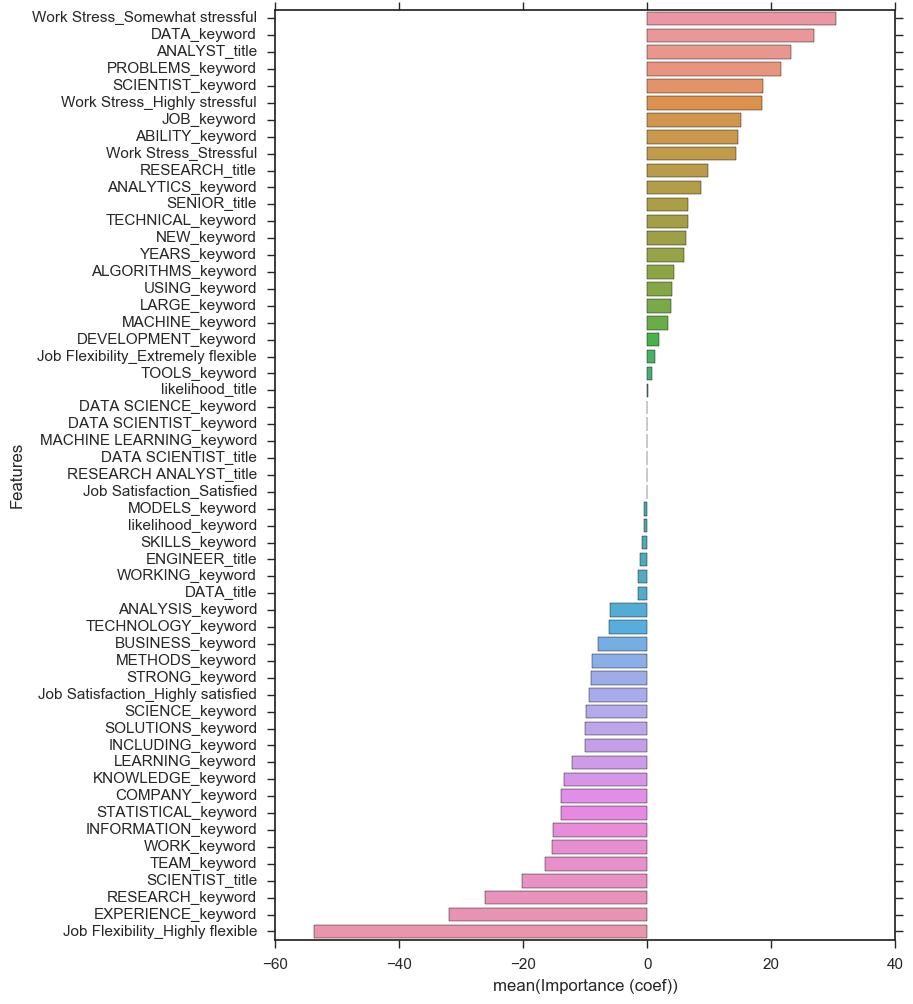

In [571]:
#Look at the most important features.
f, ax = plt.subplots(figsize=(8, 12))
sns.barplot(x='Importance (coef)', y='Features', data=log_features)

# Do a scatter plot of "likelihood keywords+titles" against salary estimate.

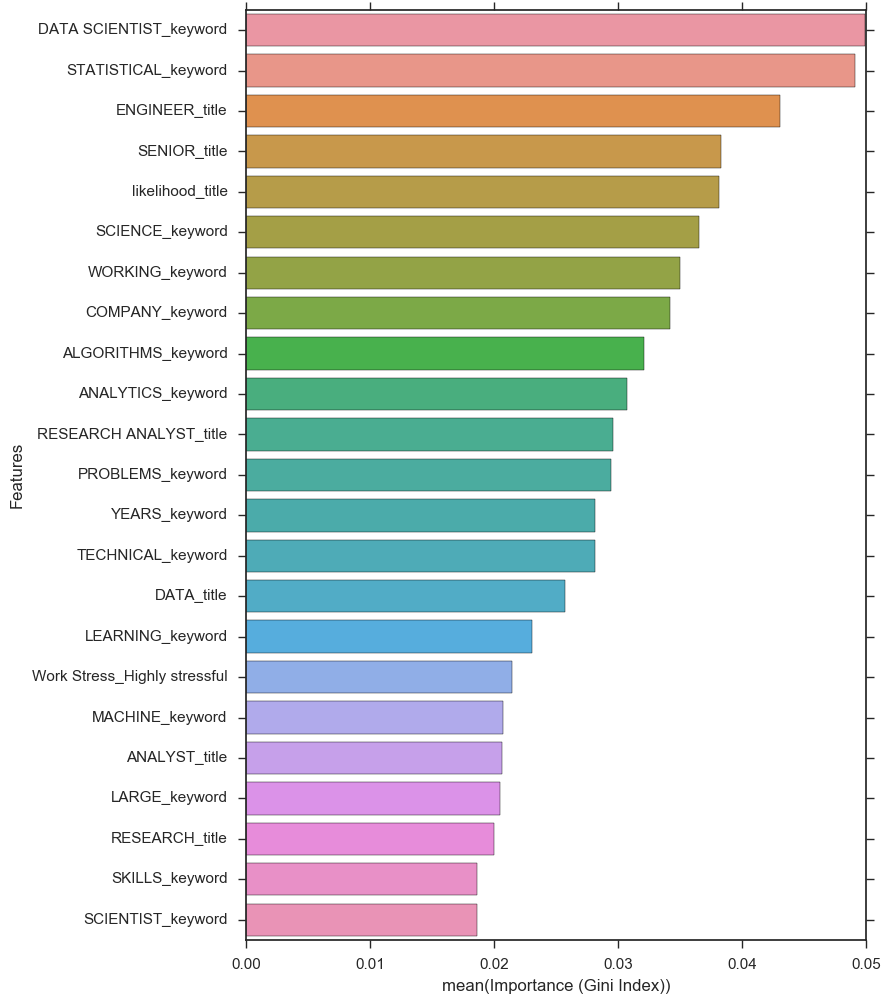

In [572]:
#Look at the most important features.
f, ax = plt.subplots(figsize=(8, 12))
sns.barplot(x='Importance (Gini Index)', y='Features', data=df_features.iloc[0:23])

In [573]:
df_features.iloc[0:50]

,Features,Importance (Gini Index)
18,DATA SCIENTIST_keyword,0.049955
12,STATISTICAL_keyword,0.049172
47,ENGINEER_title,0.043087
45,SENIOR_title,0.038337
48,likelihood_title,0.038186
7,SCIENCE_keyword,0.036519
28,WORKING_keyword,0.035016
27,COMPANY_keyword,0.034195
33,ALGORITHMS_keyword,0.032109
4,ANALYTICS_keyword,0.030765


In [574]:
df['ds_ratio'] = df['estimate']/df['likelihood_keyword']

In [575]:
df['ds_in_title'] = df['ds_in_title'].fillna(0.0)

In [576]:
df['target'] = [1.0 if x else 0.0 for x in df['estimate'] >= 85000]

In [577]:
df.columns

Index([u'title', u'company', u'url', u'location', u'desc', u'1-4',
       u'Job Flexibility', u'Job Satisfaction', u'Vacation Weeks',
       u'Work Stress', u'desc_len', u'ds_in_title', u'desc_test',
       u'title_test', u'DATA_keyword', u'EXPERIENCE_keyword', u'WORK_keyword',
       u'ANALYTICS_keyword', u'ANALYSIS_keyword', u'BUSINESS_keyword',
       u'SCIENCE_keyword', u'TEAM_keyword', u'LEARNING_keyword',
       u'SKILLS_keyword', u'NEW_keyword', u'STATISTICAL_keyword',
       u'MACHINE_keyword', u'SCIENTIST_keyword', u'ABILITY_keyword',
       u'MACHINE LEARNING_keyword', u'SOLUTIONS_keyword',
       u'DATA SCIENTIST_keyword', u'DATA SCIENCE_keyword', u'USING_keyword',
       u'RESEARCH_keyword', u'YEARS_keyword', u'TOOLS_keyword',
       u'INFORMATION_keyword', u'DEVELOPMENT_keyword', u'TECHNICAL_keyword',
       u'COMPANY_keyword', u'WORKING_keyword', u'MODELS_keyword',
       u'INCLUDING_keyword', u'TECHNOLOGY_keyword', u'JOB_keyword',
       u'ALGORITHMS_keyword', u'PROBLEMS

In [723]:
X2_test.columns

Index([u'title', u'company', u'url', u'location', u'desc', u'Job Flexibility',
       u'Job Satisfaction', u'Vacation Weeks', u'Work Stress', u'desc_len',
       u'ds_in_title', u'desc_test', u'title_test', u'DATA_keyword',
       u'EXPERIENCE_keyword', u'WORK_keyword', u'ANALYTICS_keyword',
       u'ANALYSIS_keyword', u'BUSINESS_keyword', u'SCIENCE_keyword',
       u'TEAM_keyword', u'LEARNING_keyword', u'SKILLS_keyword', u'NEW_keyword',
       u'STATISTICAL_keyword', u'MACHINE_keyword', u'SCIENTIST_keyword',
       u'ABILITY_keyword', u'MACHINE LEARNING_keyword', u'SOLUTIONS_keyword',
       u'DATA SCIENTIST_keyword', u'DATA SCIENCE_keyword', u'USING_keyword',
       u'RESEARCH_keyword', u'YEARS_keyword', u'TOOLS_keyword',
       u'INFORMATION_keyword', u'DEVELOPMENT_keyword', u'TECHNICAL_keyword',
       u'COMPANY_keyword', u'WORKING_keyword', u'MODELS_keyword',
       u'INCLUDING_keyword', u'TECHNOLOGY_keyword', u'JOB_keyword',
       u'ALGORITHMS_keyword', u'PROBLEMS_keyword', u'ST

In [ ]:
X2_test['predicted'] = y2_pred

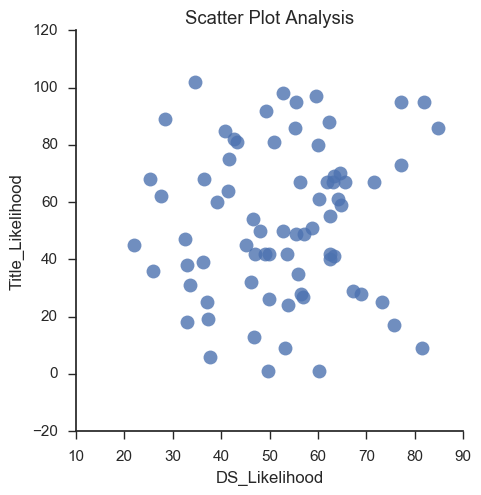

In [725]:
#Scatter plot analysis
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")


sns.lmplot('predicted', 'estimate', data=X2_test, fit_reg=False, scatter_kws={"marker": "D", "s": 100})
plt.title('Scatter Plot Analysis')
plt.xlabel('DS_Likelihood')
plt.ylabel('Title_Likelihood')

In [579]:
df[['company','likelihood_keyword', 'ds_in_title']]

,company,likelihood_keyword,ds_in_title
262,Smith Hanley Associates,0.611106,1.0
1256,UCB,0.700532,1.0
1336,Facebook,0.616334,1.0
44,"Solebrity, Inc.",0.598436,0.0
765,Dovel Technologies,0.616292,0.0
510,Dept of Forensic Sciences,0.671009,0.0
475,Dept of Forensic Sciences,0.651485,0.0
688,The Aerospace Corporation,0.637496,0.0
1062,The Aerospace Corporation,0.610304,0.0
994,The Aerospace Corporation,0.526587,0.0
